In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from PIL import Image
import glob
import os

FUNCTIONS

In [3]:
def create_gif(name='tsp_som', duration=350):
    frames = []
    imgs = glob.glob('plots\\'+name+'*.png')
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    # Save into a GIF file that loops forever
    frames[0].save(name+'.gif', format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=duration, loop=0)
    
    # delete all the images
    for i in imgs:
        os.remove(i)

In [4]:
def plot_cities(X, W, it=0, save=False, show=True):
    plt.scatter(X[:,0], X[:,1], color='darkred', label='cities')
    plt.plot(W[:,0], W[:,1], color='lightblue', label='route')
    
    if show: plt.legend()
    if save: plt.savefig('plots\\tsp_som'+str(it).zfill(4)+'.png')
    if show: plt.show()

In [5]:
def gaussian_kernel(x, sigma):
    kernel = np.exp(-np.square(x)/np.square(sigma))
    return kernel.reshape(-1, 1)

In [6]:
def elastic_band_kernel(x, sigma):
    return 'idk'

In [7]:
def calc_route_length(W):
    n = W.shape[0]
    dist_firsttolast = np.sqrt(np.sum(np.power(W[:n-1, :] - W[1:n, :], 2), axis=1)).sum()
    dist_lasttofirst = np.sqrt(np.sum(np.power(W[n-1, :] - W[0, :], 2), axis=0))
    total_distance = dist_firsttolast + dist_lasttofirst
    return total_distance

In [8]:
def SOM_ETSP(X, alpha=0.8, M=None, sigma=None, gama=0.99, beta=0.95, kernel_function=gaussian_kernel, max_iter=3000, seed=None, track=False, gif=False):
    ''' ETSP using SOM (Euclidean Traveling Salesman Problem using Self-Organizing Map).
    Parameters
    ----------
    X : array-like, shape = [n, dim]
        Input data, n is the number of cities, dim is the dimension of the problem.
    M : int
        Number of neurons.
    alpha : float
        Learning rate.
    sigma : float
        Neighborhood radius.
    gama : float
        Reduction factor of learning rate.
    beta : float
        Reduction factor of neighborhood radius.
    kernel_function : function
        Kernel function to use. Default is gaussian_kernel.
    max_iter : int
        Maximum number of iterations.
    seed : int
        Random seed.
    track : bool
        If True, print the iteration number and plot the results.
    gif : bool
        track must be True for this to work.
        If True, save the plots as images and create a gif. A folder named 'plots' must exist.
        | Warning: This might create a lot (~20) of images. These images will be deleted after the gif is created.
    Returns 
    -------
    W : array-like, shape = [M, dim]
        Weight matrix. This is the solution of ETSP. 
        It should give the route that visits all the cities in the shortest distance.
        If M>n, some of the neurons will be used to represent the same city.
    '''
    np.random.seed(seed)
    
    # Initialization
    n, dim = X.shape
    if(M is None): M = n
    if(sigma is None): sigma = M/2
    W = np.random.rand(M, dim)
    W_prev = W.copy()
    
    # Iteration
    for it in range(max_iter):
        r_order = np.random.permutation(n)  # Random order of cities

        for p in r_order:
            # Find the best matching unit
            distances = np.sum(np.power(X[p] - W, 2), axis=1)
            i_p = np.argmin(distances)
            
            # Update the weights
            order_distance = np.abs(np.arange(M) - i_p)
            d_i = np.minimum(order_distance, M - order_distance)    
            kernel = kernel_function(d_i, sigma)

            W = W + alpha * kernel * (X[p] - W)

        # Update the learning rate and neighborhood radius
        alpha = alpha * gama
        sigma = sigma * beta

        # Plot the results
        if(track and it % (max_iter/20) == 0):
            print(it)
            plot_cities(X, W, it, save=gif)
            
        # Break if the change in W's are all too small
        if np.all(np.sum(np.power(W_prev - W, 2), axis=1) < 1e-5):
            print('Stopped at iteration:', it)
            print('Route length:', calc_route_length(W))
            plot_cities(X, W, it, save=gif)
            if gif: create_gif()
            break

        # Update W_prev
        W_prev = W.copy()

    return W


# TESTS

DATA

In [9]:
data = pd.read_csv('IE440FINAL22ETSP.txt', sep = '\t', index_col='city', header = 0)

In [10]:
X_cities = data.values

### Experimental takeaways

Some experimental results about the parameters to get better results:  
gama > beta > 0.9    
M >= city count       
sigma ?

The iteration number increases when   
beta is very close to gama   
and sigma is big.

## M = n

### trial 1

Stopped at iteration: 328
Route length: 708.1000862240635


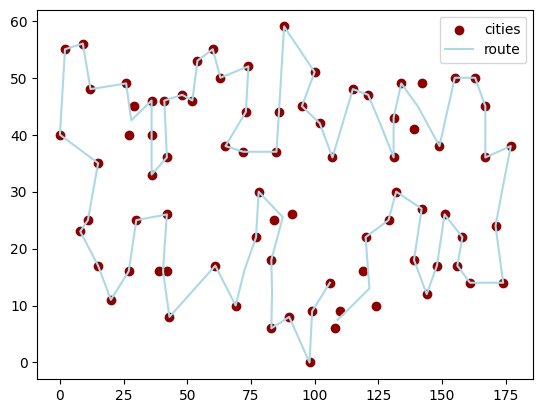

In [11]:
y = SOM_ETSP(X_cities, kernel_function=gaussian_kernel, alpha=0.75, gama=0.99, sigma=81, beta=0.95, M=81, seed=0, max_iter=10000)

The result isn't satisfying. There are some cities that are not covered.

### trial 2

Stopped at iteration: 1130
Route length: 724.7915781461614


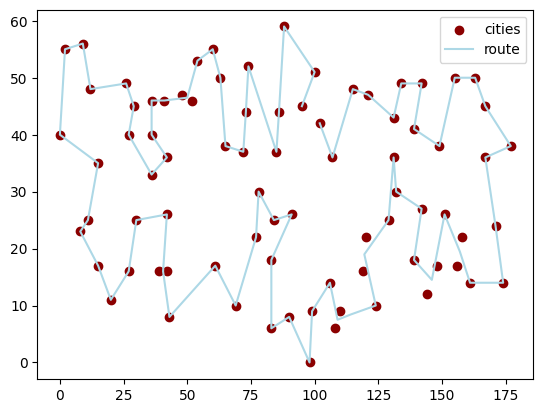

In [12]:
y = SOM_ETSP(X_cities, alpha=1, gama=0.997, sigma=5, beta=0.982, M=81, seed=0, max_iter=10000)

The result isn't satisfying. There are some cities that are not covered.

## M = 2n

### trial 1

Stopped at iteration: 127
Route length: 749.4497784867954


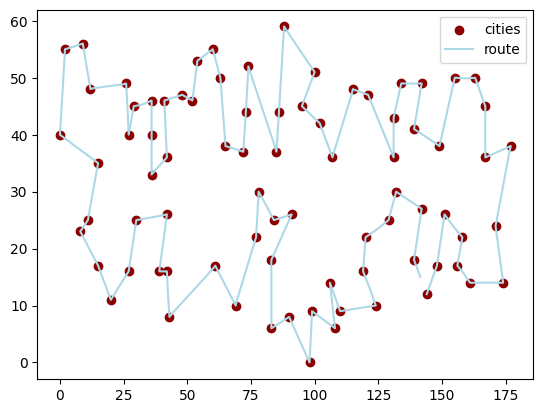

In [13]:
y = SOM_ETSP(X_cities, alpha=0.75, gama=0.99, sigma=81*2, beta=0.95, M=81*2, seed=0, max_iter=10000)

All cities are covered, this can be used as a solution.

### trial 2

Stopped at iteration: 60
Route length: 736.3255482319412


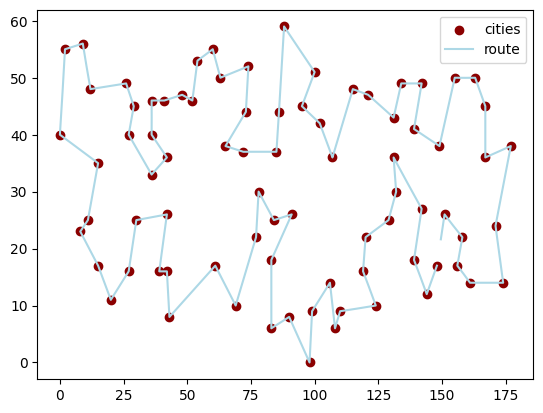

In [14]:
y = SOM_ETSP(X_cities, alpha=0.8, gama=0.995, sigma=10, beta=0.945, M=81*2, seed=0, max_iter=1000)

All cities are covered, this can be used as a solution.

## M = 3n

### trial 1

Stopped at iteration: 244
Route length: 736.3479208756254


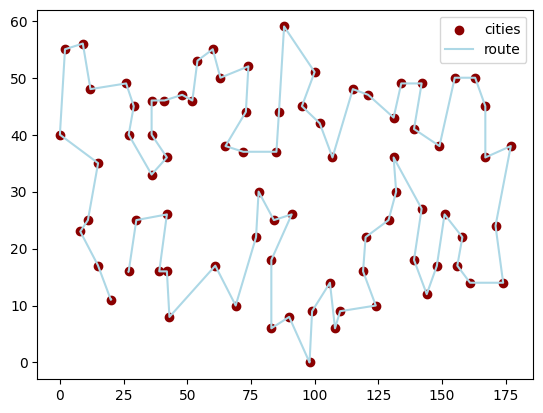

In [15]:
y = SOM_ETSP(X_cities, alpha=0.75, gama=0.999, sigma=81*3, beta=0.975, M=81*3, seed=0, max_iter=500)

All cities are covered, this can be used as a solution.

### trial 2

Stopped at iteration: 1220
Route length: 736.9615302374385


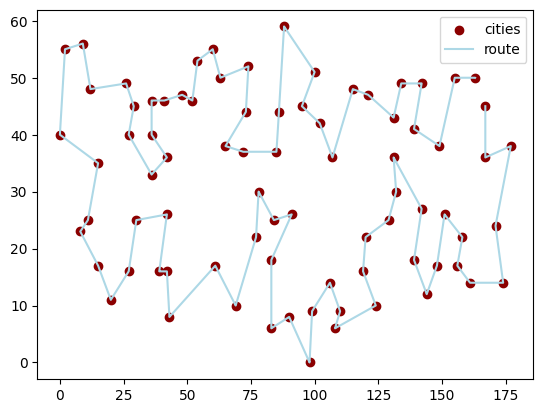

In [16]:
y = SOM_ETSP(X_cities, alpha=0.8, gama=0.99997, sigma=81*3, beta=0.995, M=81*3, seed=0, max_iter=5000)

All cities are covered, this can be used as a solution.

## Plot Route

In [17]:
blue = np.array([0.,0.,1])
red = np.array([1.,0.,0.])
def color_gradient(n, c1=blue, c2=red):
    c = []
    for i in range(n):
        k = 1-i/n
        c.append(k*c1+(1-k)*c2)
    return np.array(c)

In [18]:
def plot_route(y):
    plt.plot(y[:,0], y[:,1], color='grey')
    plt.plot(y[[-1,0],0], y[[-1,0],1], color='green')
    plt.scatter(y[:,0], y[:,1], c = color_gradient(y.shape[0]), zorder=10)
    plt.show()
    print('Route length:', calc_route_length(y))


In [19]:
def gif_route(y, k=10):
    n = y.shape[0]
    d = int(np.ceil(n/k))

    plt.scatter(X_cities[:,0], X_cities[:,1], color='darkred', zorder=10)
    plt.savefig('plots\\route'+str(0).zfill(4)+'.png')
    for i in range(0, n, d):
        plt.plot(y[i:i+d+1,0], y[i:i+d+1,1], color='grey')
        plt.savefig('plots\\route'+str(i).zfill(4)+'.png')
    plt.plot(y[[-1,0],0], y[[-1,0],1], color='green')
    plt.savefig('plots\\route'+str(9999).zfill(4)+'.png')
    plt.close()
    duration = int(10000/k)
    create_gif('route', duration)


## Best solution

Stopped at iteration: 60
Route length: 736.3255482319412


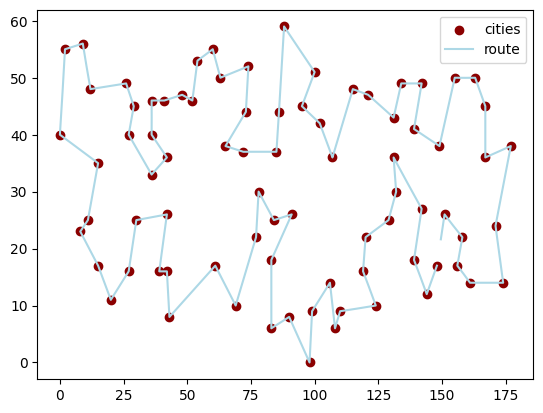

In [20]:
y_best = SOM_ETSP(X_cities, alpha=0.8, gama=0.995, sigma=10, beta=0.945, M=81*2, seed=0, max_iter=100)

In [21]:
gif_route(y_best, k=81*2)

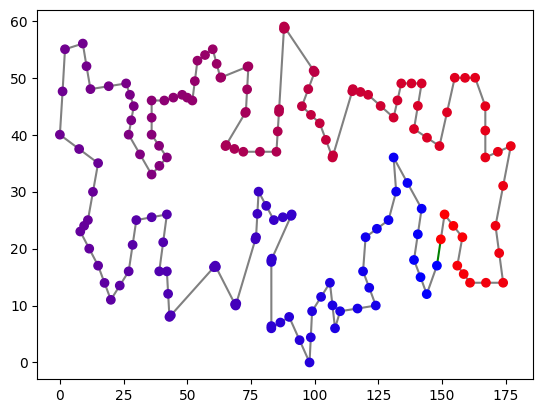

Route length: 736.3255482319412


In [22]:
plot_route(y_best)